In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation/Train.csv
/kaggle/input/customer-segmentation/Test.csv


In [2]:
data = pd.read_csv('/kaggle/input/customer-segmentation/Train.csv')
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


|Variable|	Definition|
|---|---|
|ID	Unique| ID|
|Gender|	Gender of the customer|
|Ever_Married|	Marital status of the customer|
|Age|	Age of the customer|
|Graduated|	Is the customer a graduate?|
|Profession|	Profession of the customer|
|Work_Experience|	Work Experience in years|
|Spending_Score|	Spending score of the customer|
|Family_Size|	Number of family members for the customer (including the customer)|
|Var_1|	Anonymised Category for the customer|
|Segmentation|	(target) Customer Segment of the customer|

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


# EDA

In [4]:
plot_data = data.groupby('Segmentation')['Segmentation'].agg(['count']).reset_index()

fig = px.pie(plot_data, values = plot_data['count'], names = plot_data['Segmentation'])

fig.update_traces(textposition = 'inside', textinfo = 'percent + label', hole = 0.5, 
                  marker = dict(colors = ['#2A3132','#336B87'], line = dict(color = 'white', width = 2)))

fig.update_layout(title_text = 'Customer<br>Segmentation', title_x = 0.5, title_y = 0.55, title_font_size = 26, 
                  title_font_family = 'Calibri', title_font_color = 'black', showlegend = False)
                  
fig.show()

In [5]:
def plot_category(feature, figsize=None):
    A_count = data[data['Segmentation']=='A'].groupby([feature]).size()
    B_count = data[data['Segmentation']=='B'].groupby([feature]).size()
    C_count = data[data['Segmentation']=='C'].groupby([feature]).size()
    D_count = data[data['Segmentation']=='D'].groupby([feature]).size()
    labels = A_count.index

    x = np.arange(len(labels)) # the label locations
    width = 0.7  # the width of the bars

    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots()
    rects1 = ax.bar(x-width/3, round(A_count*100/data.groupby([feature]).size(), 2), 
                    width/5, label='A')
    rects2 = ax.bar(x-width/8, round(B_count*100/data.groupby([feature]).size(), 2), 
                    width/5, label='B')
    rects3 = ax.bar(x+width/8, round(C_count*100/data.groupby([feature]).size(), 2), 
                    width/5, label='C')
    rects4 = ax.bar(x+width/3, round(D_count*100/data.groupby([feature]).size(), 2), 
                    width/5, label='D')

    ax.set_ylabel('Count')
    ax.set_title('Based on %s'%feature)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=80)
    ax.legend(loc=0, bbox_to_anchor=(1, 1));

    ax.bar_label(rects1, padding=1)
    ax.bar_label(rects2, padding=1)
    ax.bar_label(rects3, padding=1)
    ax.bar_label(rects4, padding=1)

    fig.tight_layout()
    plt.show()
    
def plot_numerical(feature, figsize=None):
    fig = plt.figure(figsize=(10,6))

    sns.kdeplot(data[data['Segmentation']=='A'][feature])
    sns.kdeplot(data[data['Segmentation']=='B'][feature])
    sns.kdeplot(data[data['Segmentation']=='C'][feature])
    sns.kdeplot(data[data['Segmentation']=='D'][feature])

    fig.legend(labels=['Segmentation A', 'Segmentation B', 'Segmentation C', 'Segmentation D'])
    plt.title('Based on %s'%feature)
    plt.show()
    
def plot_pie(feature):
    plot_data = data.groupby([feature, 'Segmentation'])[feature].agg({'count'}).reset_index()

    fig = px.sunburst(plot_data, path = [feature, 'Segmentation'], values = 'count', color = feature, 
                      title = 'Affect of %s on Customer Segmentation'%feature, width = 600, height = 600)

    fig.update_layout(plot_bgcolor = 'white', title_font_family = 'Calibri Black', title_font_color = '#221f1f', 
                      title_font_size = 22, title_x = 0.5)

    fig.update_traces(textinfo = 'label + percent parent')
    fig.show()

In [6]:
for feature in ['Gender', 'Ever_Married', 'Graduated', 'Spending_Score']:
    plot_pie(feature)

In [7]:
for feature in ['Profession', 'Var_1']:
    plot_pie(feature)

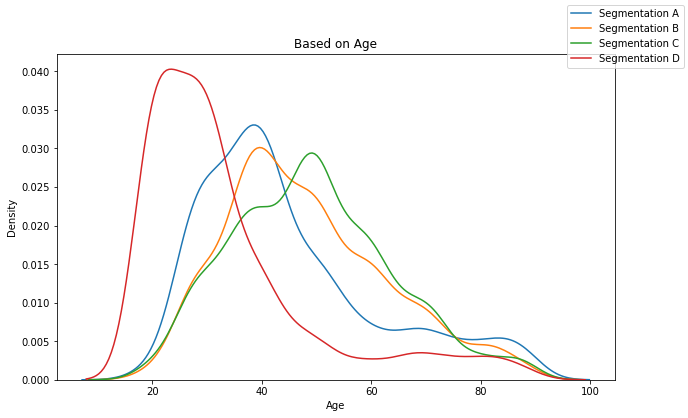

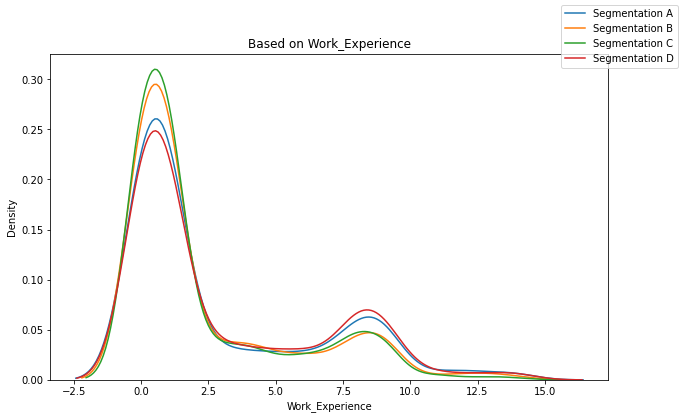

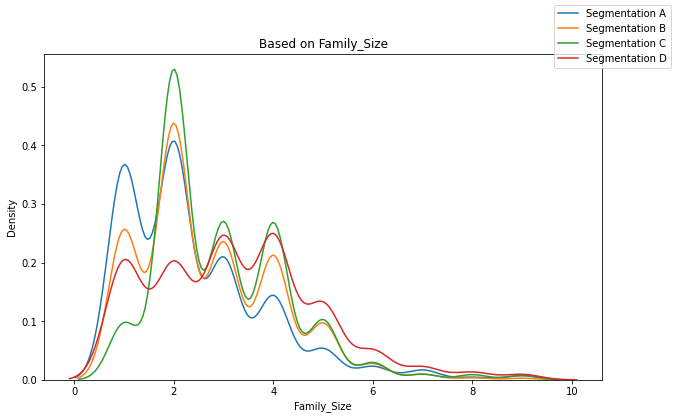

In [8]:
for feature in ['Age', 'Work_Experience', 'Family_Size']:
    plot_numerical(feature)

**Observations-**
* Ever_Married - UnMarried customers are usually in segment D while married are in segment A, B or C
* Graduated - Graduated customers are usually in segment A, B or C while Ungraduated are in segment D
* Profession - Customers in healthcare & marketing are mostly in segment D, Artist & engineers are usually in A, B or C
* Spending_Score - Usually 'Low' spenders are in segment A or D while 'high' and 'average' spenders are in segment B or C
* Age - <30 are in segment D, 30-40 or >70 are in segment A while 45-70 are in segment C
* Work_Experience - <2 are in segment C while 6-11 are in segment A & D
* Family_Size - <1 are in segment A, 1-3 are in Segment C and 4+ in segment D

In [9]:
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
numerical_features = ['Age', 'Work_Experience', 'Family_Size']

to_drop = ['ID'] # contain unique values

# CORRELATION

### Label encoding category features for correlation

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os
import joblib

In [11]:
df = data.copy()
path = '/kaggle/working'
for i, feature in enumerate(categorical_features):
    le = LabelEncoder()

    # create directory to save label encoding models
    if not os.path.exists(os.path.join(path, "TextEncoding")):
        os.makedirs(os.path.join(path, "TextEncoding"))

    # perform label encoding
    le.fit(df[feature])
    
    # save the encoder
    joblib.dump(le, open(os.path.join(path, "TextEncoding/le_{}.sav".format(feature)), 'wb'))
    
    # transfrom training data
    df[feature] = le.transform(df[feature])

    # get classes & remove first column to elude from dummy variable trap
    columns = list(map(lambda x: feature+' '+str(x), list(le.classes_)))[1:]
    
    # save classes
    joblib.dump(columns, 
                open(os.path.join(path, "TextEncoding/le_{}_classes.sav".format(feature)), 'wb'))

## Bivariate Analysis Correlation plot with the Numeric variables


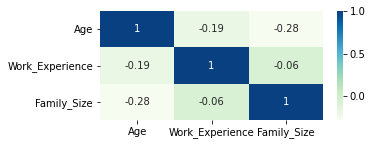

In [12]:
plt.figure(figsize=(5, 2))
sns.heatmap(round(data[numerical_features].corr(), 2), annot=True,
            mask=None, cmap='GnBu')
corr_mat = data[numerical_features].corr()
plt.show()

## Bivariate Analysis Correlation plot with the Categorical variables

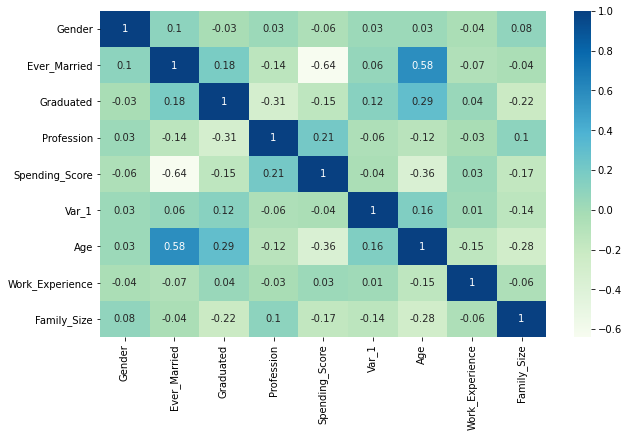

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(round(df[categorical_features+numerical_features].corr(method='spearman'), 2), annot=True,
            mask=None, cmap='GnBu')
plt.show()

**Observations-**
* Ever_Married - Spending_Score
* Ever_Married - Age

# Analyzing features using VIF

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
# Calculating VIF
vif = pd.DataFrame()
temp = df.dropna()
vif["variables"] = [feature for feature in categorical_features+numerical_features if feature not in ['Age', 'Var_1']]
vif["VIF"] = [variance_inflation_factor(temp[vif['variables']].values, i) for i in range(len(vif["variables"]))]
print(vif)

         variables       VIF
0           Gender  2.172928
1     Ever_Married  2.547924
2        Graduated  2.526486
3       Profession  2.365052
4   Spending_Score  3.231881
5  Work_Experience  1.546193
6      Family_Size  3.222219


Age and Var_1 have high VIF score

# Handling Missing Values

In [16]:
missingValueFeatures = pd.DataFrame({'missing %': data.isnull().sum()*100/len(data)})
missingValueFeatures[missingValueFeatures['missing %']>0]

,missing %
Ever_Married,1.735250
Graduated,0.966782
Profession,1.536936
Work_Experience,10.275161
Family_Size,4.152206
Var_1,0.941993


As most of the features are uncorrelated, it is difficult to fill the NA values. Hence for the time being let's drop all NA.

In [17]:
data_missing = data.dropna().reset_index(drop=True)

# Looking at Outliers

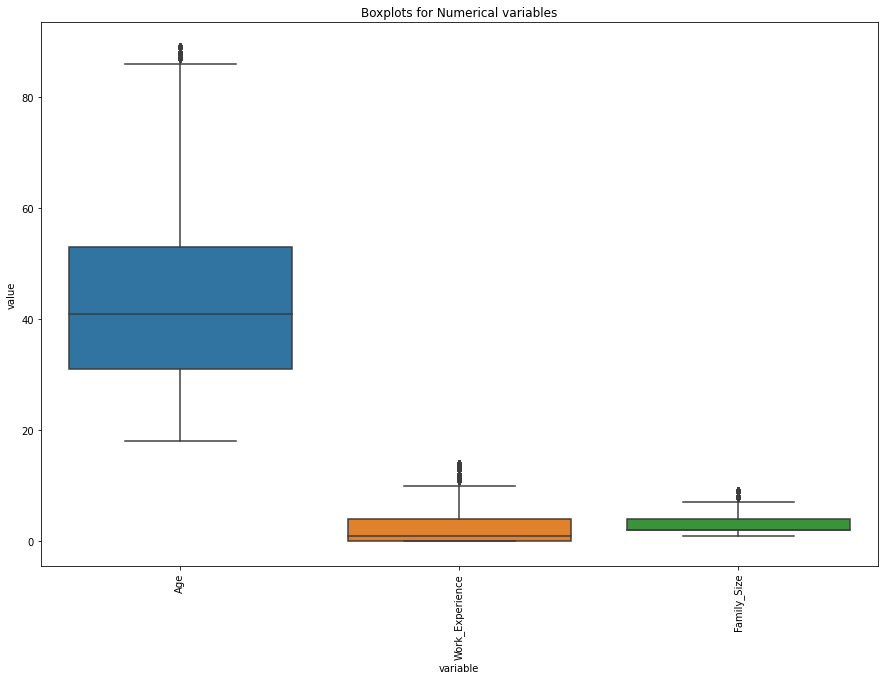

In [18]:
NumericData = data_missing[[feature for feature in numerical_features if feature not in []]]
NumericMelt = NumericData.melt()
plt.figure(figsize=(15,10))
plt.title("Boxplots for Numerical variables")
bp = sns.boxplot(x='variable', y='value', data=NumericMelt)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
plt.show()

In [19]:
# Percentage of outliers present in each variable
outlier_percentage = {}
for feature in numerical_features:
    tempData = data_missing.sort_values(by=feature)[feature]
    Q1, Q3 = tempData.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    Lower_range = Q1 - (1.5 * IQR)
    Upper_range = Q3 + (1.5 * IQR)
    outlier_percentage[feature] = round((((tempData<(Q1 - 1.5 * IQR)) | (tempData>(Q3 + 1.5 * IQR))).sum()/tempData.shape[0])*100,2)
outlier_percentage

{'Age': 1.14, 'Work_Experience': 2.64, 'Family_Size': 1.2}

# Handling Categorical Features (Label and One Hot Encoding)

In [20]:
df = data_missing.copy()
path = '/kaggle/working'
for i, feature in enumerate(categorical_features):
    
    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False)

    # create directory to save label encoding models
    if not os.path.exists(os.path.join(path, "TextEncoding")):
        os.makedirs(os.path.join(path, "TextEncoding"))

    # perform label encoding
    le.fit(df[feature])
    # save the encoder
    joblib.dump(le, open(os.path.join(path, "TextEncoding/le_{}.sav".format(feature)), 'wb'))
    
    # transfrom training data
    df[feature] = le.transform(df[feature])

    # get classes & remove first column to elude from dummy variable trap
    columns = list(map(lambda x: feature+' '+str(x), list(le.classes_)))[1:]
    
    # save classes
    joblib.dump(columns, 
                open(os.path.join(path, "TextEncoding/le_{}_classes.sav".format(feature)), 'wb'))
    # load classes
    columns = joblib.load(
        open(os.path.join(path, "TextEncoding/le_{}_classes.sav".format(feature)), 'rb'))

    if len(le.classes_)>2:
        # perform one hot encoding
        ohe.fit(df[[feature]])
        # save the encoder
        joblib.dump(ohe, open(os.path.join(path, "TextEncoding/ohe_{}.sav".format(feature)), 'wb'))

        # transfrom training data
        # removing first column of encoded data to elude from dummy variable trap
        tempData = ohe.transform(df[[feature]])[:, 1:]

        # create Dataframe with columns as classes
        tempData = pd.DataFrame(tempData, columns=columns)
    else:
        tempData = df[[feature]]
    
    # create dataframe with all the label encoded categorical features along with hot encoding
    if i==0:
        encodedData = pd.DataFrame(data=tempData, columns=tempData.columns.values.tolist())
    else:
        encodedData = pd.concat([encodedData, tempData], axis=1)

In [21]:
# merge numerical features and categorical encoded features
df = df[numerical_features+['Segmentation']]
df = pd.concat([df, encodedData], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6665 entries, 0 to 6664
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       6665 non-null   int64  
 1   Work_Experience           6665 non-null   float64
 2   Family_Size               6665 non-null   float64
 3   Segmentation              6665 non-null   object 
 4   Gender                    6665 non-null   int64  
 5   Ever_Married              6665 non-null   int64  
 6   Graduated                 6665 non-null   int64  
 7   Profession Doctor         6665 non-null   float64
 8   Profession Engineer       6665 non-null   float64
 9   Profession Entertainment  6665 non-null   float64
 10  Profession Executive      6665 non-null   float64
 11  Profession Healthcare     6665 non-null   float64
 12  Profession Homemaker      6665 non-null   float64
 13  Profession Lawyer         6665 non-null   float64
 14  Professi

# Training Model

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier

In [23]:
train_data = df.copy()
feature_cols = [feature for feature in train_data.columns if feature not in(['Segmentation'])]
print('features used- ', feature_cols)

''' Rescaling to [0,1] '''
scaler = StandardScaler()
scaler.fit(train_data[feature_cols])
train_data[feature_cols] = scaler.transform(train_data[feature_cols])

features used-  ['Age', 'Work_Experience', 'Family_Size', 'Gender', 'Ever_Married', 'Graduated', 'Profession Doctor', 'Profession Engineer', 'Profession Entertainment', 'Profession Executive', 'Profession Healthcare', 'Profession Homemaker', 'Profession Lawyer', 'Profession Marketing', 'Spending_Score High', 'Spending_Score Low', 'Var_1 Cat_2', 'Var_1 Cat_3', 'Var_1 Cat_4', 'Var_1 Cat_5', 'Var_1 Cat_6', 'Var_1 Cat_7']


In [24]:
train_data['Segmentation'] = train_data['Segmentation'].map({'A':0, 'B':1, 'C':2, 'D':3})
X = train_data[feature_cols]
y = train_data['Segmentation']

validation_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, 
                                                    random_state=0, stratify=y)

# Model 1: Logistic Regression

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
y_pred = model.predict(X_train)

print('Train metrics...')
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)

print('Validation metrics...')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train metrics...
[[609 150 235 218]
 [339 267 453 120]
 [168 157 810 155]
 [270  69  64 914]]
              precision    recall  f1-score   support

           0       0.44      0.50      0.47      1212
           1       0.42      0.23      0.29      1179
           2       0.52      0.63      0.57      1290
           3       0.65      0.69      0.67      1317

    accuracy                           0.52      4998
   macro avg       0.51      0.51      0.50      4998
weighted avg       0.51      0.52      0.51      4998

Validation metrics...
[[211  54  70  69]
 [120  90 135  48]
 [ 54  40 285  51]
 [ 96  22  19 303]]
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       404
           1       0.44      0.23      0.30       393
           2       0.56      0.66      0.61       430
           3       0.64      0.69      0.67       440

    accuracy                           0.53      1667
   macro avg       0.52      0.53      0.51   

In [27]:
''' metrics on original data '''
y_pred = model.predict(train_data[feature_cols])

def make_cm(matrix, columns):
    n = len(columns)
    act = ['actual Segmentation'] * n
    pred = ['predicted Segmentation'] * n

    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

df_matrix=make_cm(
    confusion_matrix(train_data['Segmentation'], y_pred),['A', 'B', 'C', 'D'])

display(df_matrix)
print(classification_report(train_data['Segmentation'], y_pred))

predicted Segmentation                 
                                           A    B     C     D
actual Segmentation A                    820  204   305   287
                    B                    459  357   588   168
                    C                    222  197  1095   206
                    D                    366   91    83  1217

              precision    recall  f1-score   support

           0       0.44      0.51      0.47      1616
           1       0.42      0.23      0.29      1572
           2       0.53      0.64      0.58      1720
           3       0.65      0.69      0.67      1757

    accuracy                           0.52      6665
   macro avg       0.51      0.52      0.50      6665
weighted avg       0.51      0.52      0.51      6665



# Model 2: XGB

In [28]:
model = XGBClassifier(
    learning_rate=0.05, 
    max_depth=3,
    min_child_weight=5, 
    n_estimators=1000, 
    random_state=7, 
    reg_lambda=1.5,
    reg_alpha=0.5,
    use_label_encoder=False
)

model.fit(X_train, y_train,
          eval_metric='mlogloss',
          verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=7, reg_alpha=0.5,
              reg_lambda=1.5, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [29]:
y_pred = model.predict(X_train)

print('Train metrics...')
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)

print('Test metrics...')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train metrics...
[[ 736  173  135  168]
 [ 234  513  313  119]
 [ 112  171  859  148]
 [ 204   64   27 1022]]
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1212
           1       0.56      0.44      0.49      1179
           2       0.64      0.67      0.65      1290
           3       0.70      0.78      0.74      1317

    accuracy                           0.63      4998
   macro avg       0.62      0.62      0.62      4998
weighted avg       0.62      0.63      0.62      4998

Test metrics...
[[191  89  45  79]
 [106 126 114  47]
 [ 42  73 265  50]
 [ 89  27  24 300]]
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       404
           1       0.40      0.32      0.36       393
           2       0.59      0.62      0.60       430
           3       0.63      0.68      0.66       440

    accuracy                           0.53      1667
   macro avg       0.52      0.52   

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [30]:
''' metrics on original data '''
y_pred = model.predict(train_data[feature_cols])

def make_cm(matrix, columns):
    n = len(columns)
    act = ['actual Segmentation'] * n
    pred = ['predicted Segmentation'] * n

    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

df_matrix=make_cm(
    confusion_matrix(train_data['Segmentation'], y_pred),['A', 'B', 'C', 'D'])

display(df_matrix)
print(classification_report(train_data['Segmentation'], y_pred))

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



predicted Segmentation                 
                                           A    B     C     D
actual Segmentation A                    927  262   180   247
                    B                    340  639   427   166
                    C                    154  244  1124   198
                    D                    293   91    51  1322

              precision    recall  f1-score   support

           0       0.54      0.57      0.56      1616
           1       0.52      0.41      0.46      1572
           2       0.63      0.65      0.64      1720
           3       0.68      0.75      0.72      1757

    accuracy                           0.60      6665
   macro avg       0.59      0.60      0.59      6665
weighted avg       0.60      0.60      0.60      6665



# Model 3: Deep Learning

In [31]:

np.random.seed(123)  # for reproducibility

import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout

In [32]:
# Initialize the constructor
model = Sequential()
# Add an input layer 
# arguemtns of dense: output shape, activation, input shape
# activation(define the output function) = [relu', 'tanh']
model.add(Dense(64, activation='relu', input_shape=(len(feature_cols),)))
model.add(Dropout(0.3))
# Add one hidden layer 
# after first layer no need to give input shape
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
# Add an output layer 
# activation = [regression: 'linear', binary classification: 'sigmoid', multiclass: 'softmax']
# threshold: >0 or <0
# sigmoid: 1/(1+e^-x), usually applied in output layer
# rectifier: max(x,0), usually applied in hidden layer: relu
# hyperbolic tangent tanh: (1-e^-2x)/(1+e^-2x)
model.add(Dense(4, activation='softmax'))

# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# loss = [regression: 'mse', binary: 'binary_crossentropy', multi: 'categorical_crossentropy']
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy']
         )

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1472      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1

In [33]:
fit = model.fit(X_train, pd.get_dummies(y_train), epochs=150, batch_size=500, verbose=1, validation_split=0.2)

Epoch 1/150
8/8 [==============================] - 2s 111ms/step - loss: 1.4294 - accuracy: 0.2535 - val_loss: 1.3601 - val_accuracy: 0.3250
Epoch 2/150
8/8 [==============================] - 0s 12ms/step - loss: 1.3782 - accuracy: 0.2919 - val_loss: 1.3356 - val_accuracy: 0.3550
Epoch 3/150
8/8 [==============================] - 0s 12ms/step - loss: 1.3669 - accuracy: 0.2921 - val_loss: 1.3160 - val_accuracy: 0.3670
Epoch 4/150
8/8 [==============================] - 0s 12ms/step - loss: 1.3455 - accuracy: 0.3148 - val_loss: 1.2984 - val_accuracy: 0.3700
Epoch 5/150
8/8 [==============================] - 0s 12ms/step - loss: 1.3171 - accuracy: 0.3304 - val_loss: 1.2825 - val_accuracy: 0.3760
Epoch 6/150
8/8 [==============================] - 0s 12ms/step - loss: 1.2983 - accuracy: 0.3594 - val_loss: 1.2667 - val_accuracy: 0.3800
Epoch 7/150
8/8 [==============================] - 0s 12ms/step - loss: 1.3002 - accuracy: 0.3616 - val_loss: 1.2539 - val_accuracy: 0.3930
Epoch 8/150
8/8 [==

53/53 [==============================] - 0s 1ms/step - loss: 1.0584 - accuracy: 0.5279


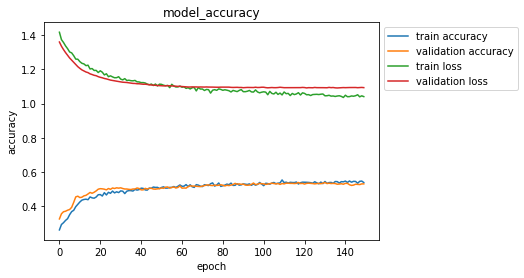

In [34]:
# Final evaluation of the model
loss, accuracy = model.evaluate(X_test, pd.get_dummies(y_test), verbose=1)
#print("Accuracy: ", accuracy*100, "%")

# plot training vs validation for overfiiting
plt.plot(fit.history['accuracy'], label='train accuracy')
plt.plot(fit.history['val_accuracy'], label='validation accuracy')
plt.plot(fit.history['loss'], label='train loss')
plt.plot(fit.history['val_loss'], label='validation loss')
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()